# Orthgonal Chirp


In [146]:
%matplotlib inline

from numpy import zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt, log10
from scipy.io.wavfile import write
from scipy.signal import spectrogram, butter, buttord, lfilter
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [147]:
SAMPLING_RATE = 100000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Carrier in Hz
CARRIER=18000

WAVE_FILE="./ChirpTone.wav"

In [148]:
F0 = 16000
F1 = 19000

## Chirp tone synthesis

In [149]:
# Complex version of chirp tone generator
def chirp(f0=F0, f1=F1, amp=AMPLITUDE, updown="up", T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    k = float(f1 - f0)/float(T)
    if (updown == "up"):
        f = f0 + k * t / 2.0
    elif (updown == "down"):
        f = f1 - k * t / 2.0
    arg = (2.0 * pi * f * t) * rot + phase
    return exp(1j * arg) * amp

# White noise generator
def white_noise(amp=AMPLITUDE, T=TIME_FRAME):
    a = random.random(int(T * SAMPLING_RATE)) * 2 * amp - amp
    b = random.random(int(T * SAMPLING_RATE)) * 2 * amp - amp
    return a + 1j * b

# Constant noise generator
def constant_noise(f=0, amp=AMPLITUDE, T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    arg = (2 * pi * f * t) * rot + phase
    return exp(1j * arg) * amp

## FFT/IFFT functions

In [161]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

# Plot wave
def plot_wave(wave, real_only=True, logscale=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)

    re = real(wave)
    im = imag(wave)
    if logscale:
        re = 10 * log10(re)
        im = 10 * log10(im)
        plt.ylabel('Amplitude(dB)')
    else:
        plt.ylabel('Amplitude')

    if real_only:
        plt.plot(t, re)
    else:
        plt.plot(t, re)
        plt.plot(t, im)

    plt.xlabel('Time [sec]')
    plt.title("Time domain")

## Baseband signal

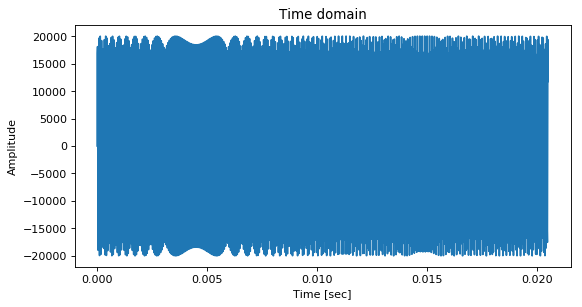

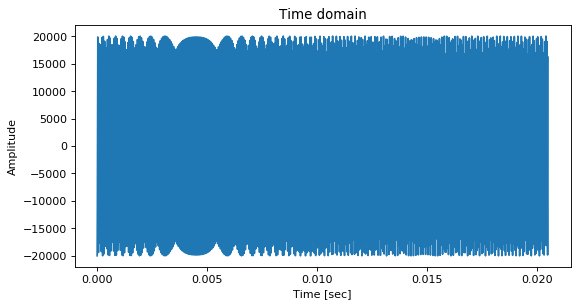

In [162]:
plot_wave(chirp_cos())
plot_wave(chirp_sin())

## Modulation

Frequencies at peaks: [-18701.171875 -16357.421875  16357.421875  18701.171875] Hz
Frequencies at peaks: [-18701.171875 -16357.421875  16357.421875  18701.171875] Hz


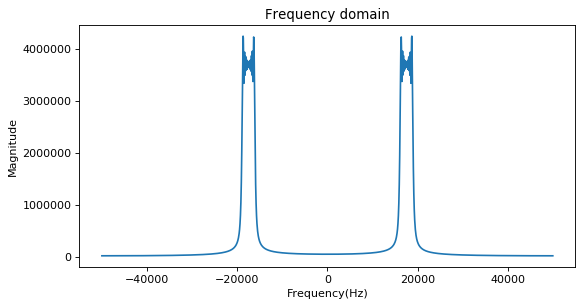

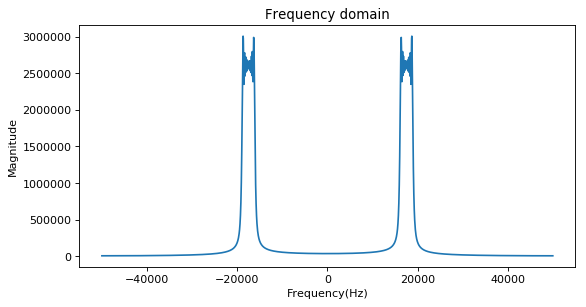

In [163]:
Ccos = real(chirp())
Csin = imag(chirp())

W1 = Ccos - Csin
W2 = Ccos
plot_fft(W1)
plot_fft(W2)

## Demodulation under noise

Frequencies at peaks: [0.] Hz
Frequencies at peaks: [33789.0625 35546.875 ] Hz
Frequencies at peaks: [16357.421875 17138.671875 33837.890625 34521.484375 36181.640625] Hz
Frequencies at peaks: [-1171.875      537.109375] Hz


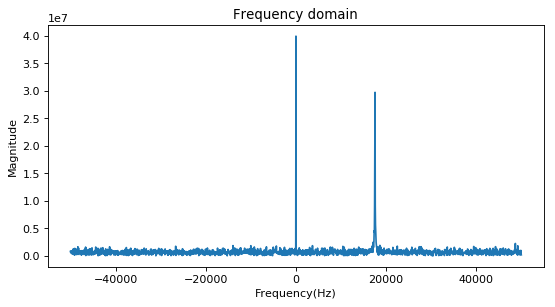

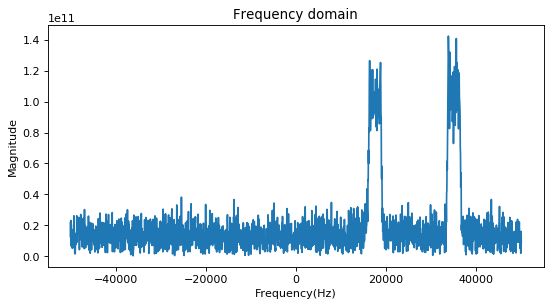

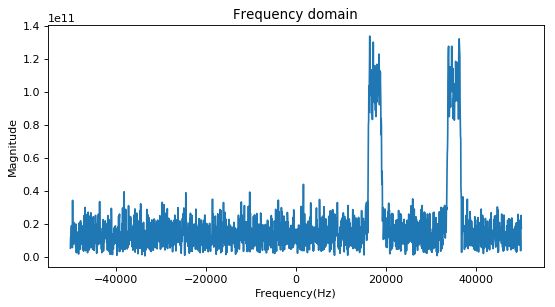

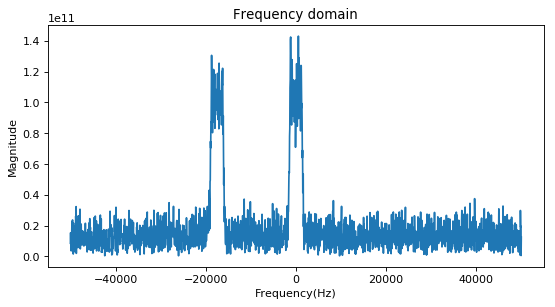

In [181]:
noise = white_noise() + constant_noise(f=0) + constant_noise(f=F0+(F1-F0)/2)

plot_fft(noise)

Nd = noise * chirp(updown="down")
Nu = noise * chirp(updown="up")
Nc = noise * chirp().conjugate()

plot_fft(Nd)
plot_fft(Nu)
plot_fft(Nc)

Frequencies at peaks: [35009.765625] Hz
Frequencies at peaks: [0.] Hz
Frequencies at peaks: [0.] Hz
Frequencies at peaks: [35009.765625] Hz
Frequencies at peaks: [0.] Hz


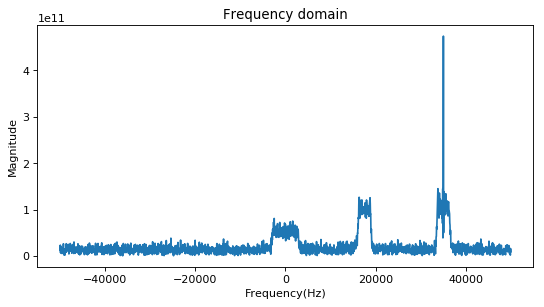

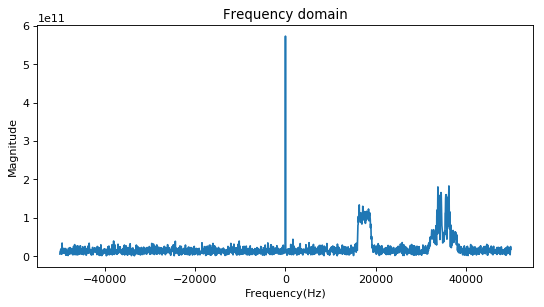

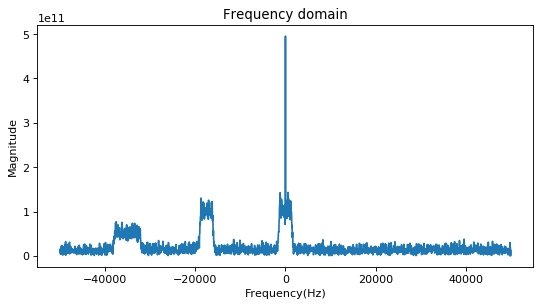

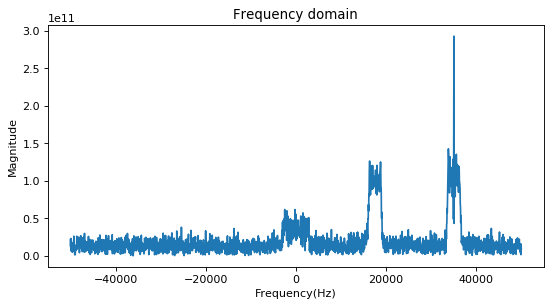

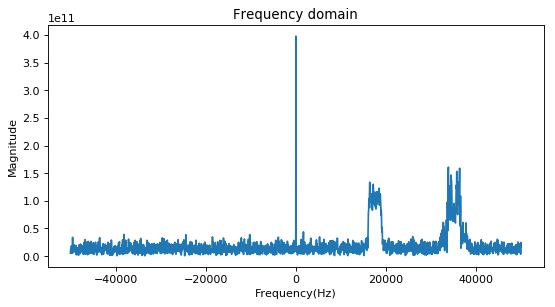

In [182]:
R1d = (W1 + noise) * chirp(updown="down")
R1u = (W1 + noise) * chirp(updown="up")
R1c = (W1 + noise) * chirp().conjugate()

R2d = (W2 + noise) * chirp(updown="down")
R2u = (W2 + noise) * chirp(updown="up")

plot_fft(R1d)
plot_fft(R1u)
plot_fft(R1c)

plot_fft(R2d)
plot_fft(R2u)

## Synchronous addition improves SNR if constant noises exist randomly in the bandwidth

Frequencies at peaks: [35009.765625] Hz
Frequencies at peaks: [35009.765625] Hz
Frequencies at peaks: [35009.765625] Hz
Frequencies at peaks: [0.] Hz
Frequencies at peaks: [0.] Hz
Frequencies at peaks: [0.] Hz


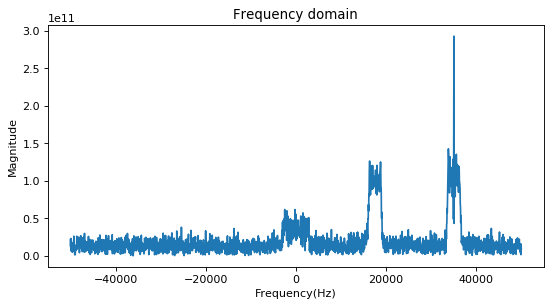

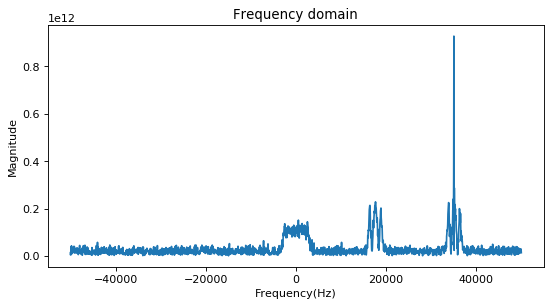

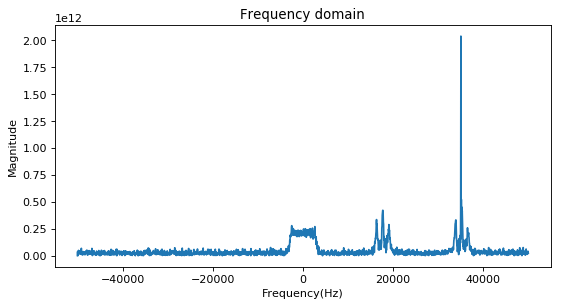

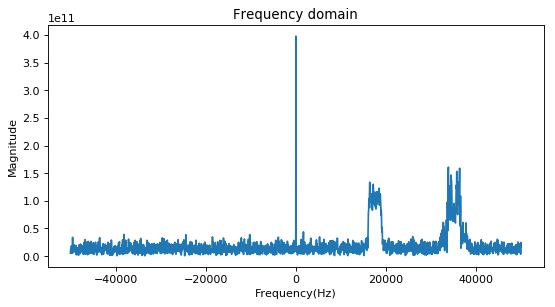

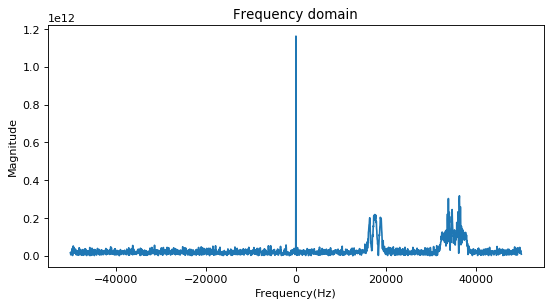

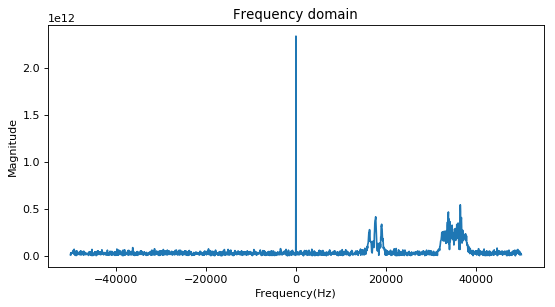

In [189]:
noise = white_noise() + constant_noise(f=0) + constant_noise(f=F0+(F1-F0)/2)
noise2 = white_noise() + constant_noise(f=100) + constant_noise(f=F0+(F1-F0)/2+100)
noise3 = white_noise() + constant_noise(f=200) + constant_noise(f=F0+(F1-F0)/2+200)
noise4 = white_noise() + constant_noise(f=300) + constant_noise(f=F0+(F1-F0)/2+300)

R3d = (W1 + W1 + noise + noise2) * chirp(updown="down")
R3u = (W1 + W1 + noise + noise2) * chirp(updown="up")

R4d = (W1 + W1 + W1 + W1 + noise + noise2 + noise3 + noise4) * chirp(updown="down")
R4u = (W1 + W1 + W1 + W1 + noise + noise2 + noise3 + noise4) * chirp(updown="up")

plot_fft(R2d)
plot_fft(R3d)
plot_fft(R4d)

plot_fft(R2u)
plot_fft(R3u)
plot_fft(R4u)